In [3]:
from clearml import Task

dataset = 'Adult'
task_filter={
    # filter out archived Tasks
    'system_tags': ['-archived'],
    # only completed & published Tasks
    'status': ['completed'],
    # only training type Tasks
    'type': ['training']
}
tags = [dataset]
task_list = Task.get_tasks(
    task_ids=None,  # type Optional[Sequence[str]]
    project_name="AI Fairness",  # Optional[str]
    task_name=None,  # Optional[str]
    task_filter=task_filter,  # Optional[Dict]
    tags=tags
)





In [47]:
from clearml import Task

# Initialize the ClearML Task object
task_list_remove = Task.get_tasks(
    task_ids=None,  # type Optional[Sequence[str]]
    project_name="AI Fairness",  # Optional[str]
    task_name=None,  # Optional[str]
)

In [48]:
from tqdm import tqdm
for i in tqdm(task_list_remove):
    try:
        i.delete()
    except Exception:
        pass

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [01:40<00:00,  5.29s/it]


In [6]:
sensattr = ['sex']
ages = [(71, 75)]
privacy_in = [[]]#[['autoencoder'], ['classifier'], ['adversary'], []]
eps = [1]#, 3, 10, 30]
arch = ['DP']#, 'EOD']
len(task_list)

14

In [16]:
dp = []
eod = []
eop = []
for i in task_list:
    scalars = i.get_reported_scalars()
    dp.append(scalars['ΔDP'][f'Dem_Par test']['y'][-1])
    eod.append(scalars['ΔEOD'][f'Dem_Par test']['y'][-1])
    eop.append(scalars['ΔEOP'][f'Dem_Par test']['y'][-1])

In [46]:
eop[5::7]

[0.14844994246959686, 0.06863882392644882]

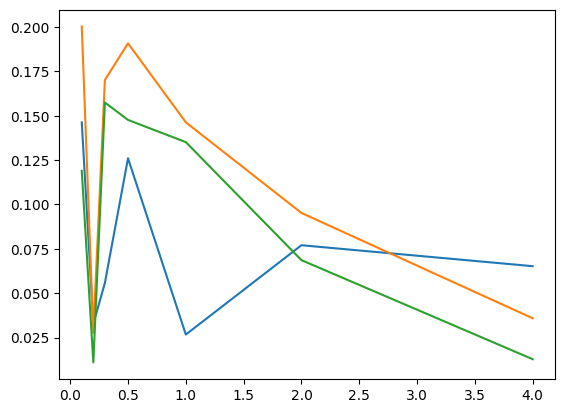

In [28]:
x = [0.1, 0.2, 0.3, 0.5, 1, 2, 4]
plt.plot(x, dp[:4] + dp[len(x)+4:])
plt.plot(x, eod[:4] + eod[len(x)+4:])
plt.plot(x, eop[:4] + eop[len(x)+4:])

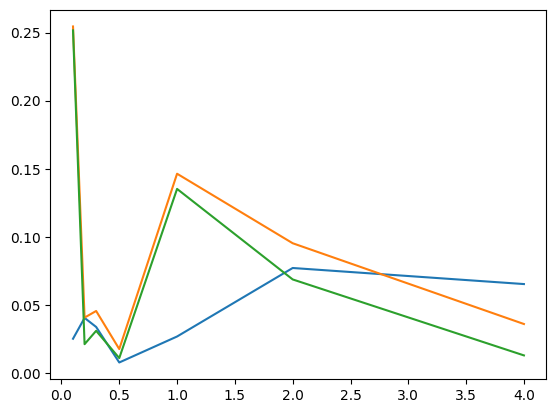

In [29]:
x = [0.1, 0.2, 0.3, 0.5, 1, 2, 4]
plt.plot(x, dp[len(x):])
plt.plot(x, eod[len(x):])
plt.plot(x, eop[len(x):])

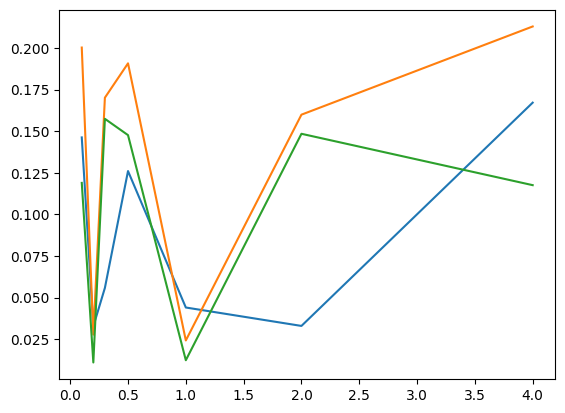

In [30]:
x = [0.1, 0.2, 0.3, 0.5, 1, 2, 4]
plt.plot(x, dp[:len(x)])
plt.plot(x, eod[:len(x)])
plt.plot(x, eop[:len(x)])

In [7]:
import itertools
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
comb = list(itertools.product(sensattr, ages, privacy_in, arch))
metric_name = ['Accuracy', 'Accuracy Unfair', 'Accuracy AE',
               'ΔDP', 'ΔDP Unfair', 'ΔDP AE',
               'ΔEOD', 'ΔEOD Unfair', 'ΔEOD AE',
               'Acc/Fairness DP', 'Acc/Fairness DP Unfair', 'Acc/Fairness EOD', 'Acc/Fairness EOD Unfair']
print(comb)

[('sex', (71, 75), [], 'DP')]


In [8]:
def gen_label(l):
    str_ = l[0] if l[0] == 'age' else 'gender'
    if l[0] == 'age':
        str_ += f' {l[1][0]}-{l[1][1]}'
    str_+='|'
    if len(l[2]) > 0:
        str_ += ' Privacy in'
    else:
        str_ += ' No privacy'
    for p in l[2]:
        str_ += f' {p}'
    str_+='|'
    str_ += f' {l[3]}'
    return str_

In [9]:
all_metrics = []
for c in tqdm(comb):
    metrics = {n:{k:[] for k in eps} for n in metric_name}
    for task in task_list:
        p = task.get_parameters_as_dict()
        p_in = ast.literal_eval(p['Args']['privacy_in']) if len(p['Args']['privacy_in']) > 0 else []
        if all([
            p['Args']['sensattr'] == c[0], p_in == c[2], p['Args']['arch'] == c[3]
        ]):
            if p['Args']['aeweight'] == '1' and p_in != []:
                scalars = task.get_reported_scalars()
                arch_ = p['General']['arch']
                e = int(p['Args']['eps'])
                metrics['Accuracy AE'][e].append(scalars['Accuracy'][f'{arch_} test']['y'][-1])
                metrics['ΔDP AE'][e].append(scalars['ΔDP'][f'{arch_} test']['y'][-1])
                metrics['ΔEOD AE'][e].append(scalars['ΔEOD'][f'{arch_} test']['y'][-1])
            else:
                scalars = task.get_reported_scalars()
                arch_ = p['General']['arch']
                e = int(p['Args']['eps'])
                metrics['Acc/Fairness DP'][e].append(scalars['Test Acc/Fair'][f'DP']['y'][-1])
                metrics['Acc/Fairness DP Unfair'][e].append(scalars['Test Acc/Fair'][f'DP Unfair']['y'][-1])
                metrics['Acc/Fairness EOD'][e].append(scalars['Test Acc/Fair'][f'EOD']['y'][-1])
                metrics['Acc/Fairness EOD Unfair'][e].append(scalars['Test Acc/Fair'][f'EOD Unfair']['y'][-1])
                metrics['Accuracy'][e].append(scalars['Accuracy'][f'{arch_} test']['y'][-1])
                metrics['ΔDP'][e].append(scalars['ΔDP'][f'{arch_} test']['y'][-1])
                metrics['ΔEOD'][e].append(scalars['ΔEOD'][f'{arch_} test']['y'][-1])
                metrics['Accuracy Unfair'][e].append(scalars['Accuracy']['Unfair test']['y'][-1])
                metrics['ΔDP Unfair'][e].append(scalars['ΔDP']['Unfair test']['y'][-1])
                metrics['ΔEOD Unfair'][e].append(scalars['ΔEOD']['Unfair test']['y'][-1])
    for m in metrics:
        for i in metrics[m]:
            metrics[m][i] = (np.mean(metrics[m][i]), np.std(metrics[m][i], ddof=1), metrics[m][i])
    all_metrics.append(metrics)
    
            

  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]D:\work\Projects\Programming\PythonProjects\DPFairDeepLearning\venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\work\Projects\Programming\PythonProjects\DPFairDeepLearning\venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\work\Projects\Programming\PythonProjects\DPFairDeepLearning\venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\work\Projects\Programming\PythonProjects\DPFairDeepLearning\venv\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(ar

In [477]:
def gen_l(name):
    l = []
    for s, m in enumerate(all_metrics):
        mean, std, raw = [], [], []
        for i in m[name]:
            mean.append(m[name][i][0])
            std.append(m[name][i][1])
            raw.append(m[name][i][2])
        l.append([mean, std, raw])
    return l

In [478]:

def plot_res(fig_, ax_, l, name, label_list):
    for j, i in enumerate(l):
        ax_.bar(np.arange(len(eps)) + 0.8/len(l)*j, i[0], yerr=i[1], width=0.8/len(l), label=gen_label(label_list[j]))
        print(gen_label(label_list[j]), [round(s,3) for s in i[0]], [round(s,3) for s in i[1]])
    ax_.set_title(f'Dependence of {name} on epsilon')
    ax_.set_xticks(np.arange(len(eps)))
    ax_.set_xticklabels(eps)
    ax_.set_xlabel('eps')
    ax_.set_ylabel(name)
    ax_.legend(loc=1)
    fig_.tight_layout()
    return ax

In [479]:
def add_no_pr(ax_, g, comb_, n='Accuracy', color='r'):
    from matplotlib.collections import LineCollection
    x = np.arange(-0.2 ,len(eps))
    y = np.repeat(g[0][0], len(x))
    print(gen_label(comb_), round(g[0][0],3), round(g[1][0],3))
    ax_.plot(x, y, label=gen_label(comb_),c=color)
    ax_.legend(loc=1)
    return ax_

In [519]:
def add_unfair(ax_, n='Accuracy'):
    x = np.arange(-0.2 ,len(eps))
    y = np.repeat(gen_l(f'{n} Unfair')[0][0][0], len(x))
    print('gender| No privacy| Unfair', gen_l(f'{n} Unfair')[0][0][0])
    ax_.plot(x, y, label='gender| No privacy| Unfair',c='black', linestyle='dashed')
    ax_.legend(loc=3)
    return ax_

## test

gender| Privacy in autoencoder| DP [0.136, 0.153, 0.15, 0.114] [0.019, 0.004, 0.009, 0.062]
gender| Privacy in classifier| DP [0.12, 0.129, 0.115, 0.12] [0.054, 0.035, 0.036, 0.02]
gender| Privacy in adversary| DP [0.136, 0.139, 0.151, 0.145] [0.028, 0.015, 0.005, 0.007]
gender| No privacy| DP 0.13 0.05
gender| No privacy| Unfair 0.16537350416183472
gender| Privacy in autoencoder| EOD [0.133, 0.15, 0.157, 0.153] [0.034, 0.01, 0.013, 0.006]
gender| Privacy in classifier| EOD [0.111, 0.124, 0.132, 0.122] [0.037, 0.023, 0.018, 0.018]
gender| Privacy in adversary| EOD [0.128, 0.148, 0.137, 0.151] [0.042, 0.004, 0.021, 0.006]
gender| No privacy| EOD 0.153 0.006
gender| No privacy| Unfair 0.16537350416183472
gender| Privacy in autoencoder| DP [0.136, 0.153, 0.15, 0.114] [0.019, 0.004, 0.009, 0.062]
gender| Privacy in autoencoder| EOD [0.133, 0.15, 0.157, 0.153] [0.034, 0.01, 0.013, 0.006]
gender| No privacy| DP 0.13 0.05
gender| No privacy| EOD 0.153 0.006
gender| No privacy| Unfair 0.165373

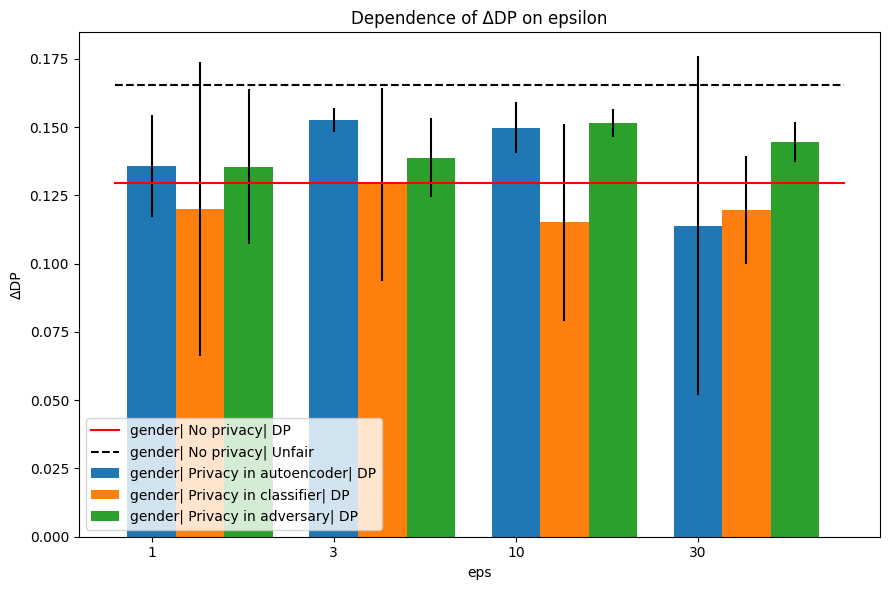

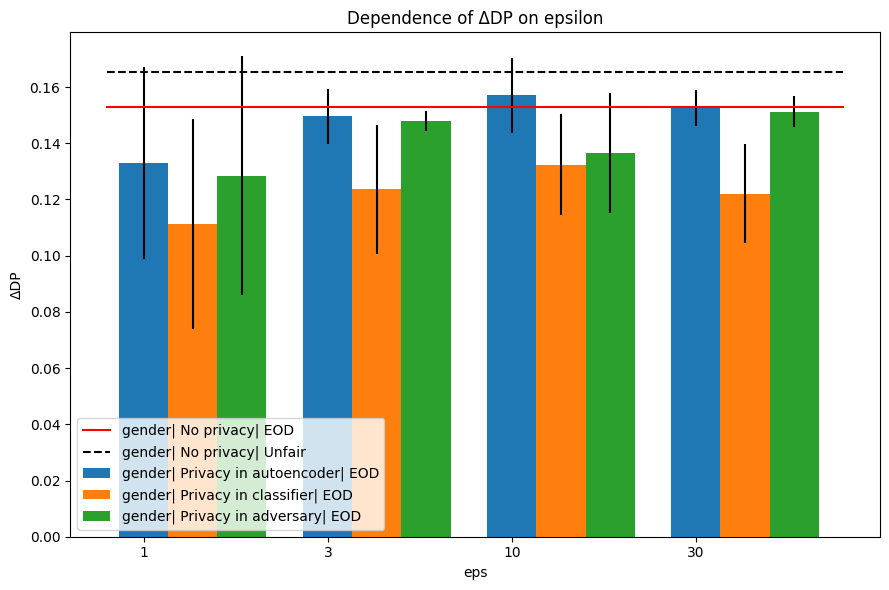

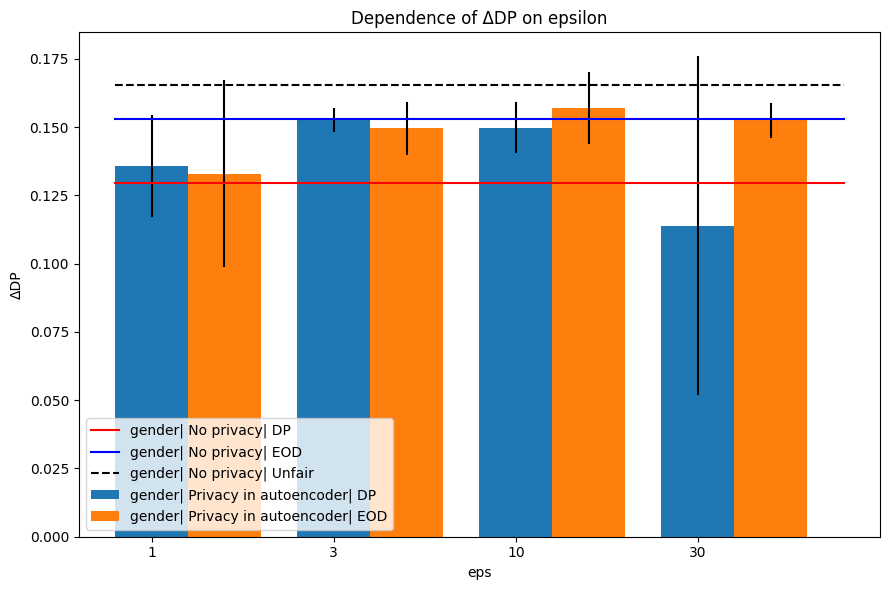

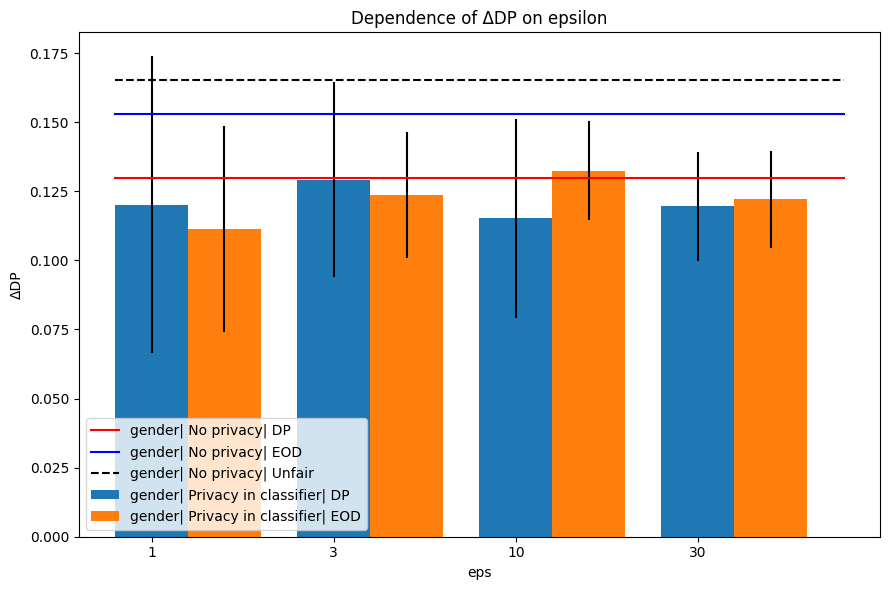

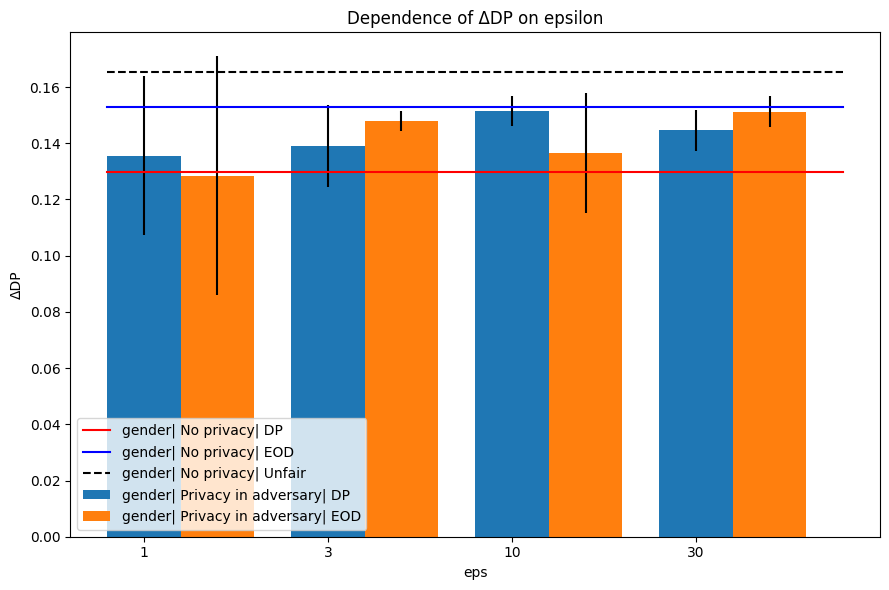

In [521]:
colors = ['r', 'b']
metrics = ['ΔDP']
ids_bar = [
    (0, 2, 4),
    (1, 3, 5),
    (0, 1),
    (2, 3),
    (4, 5)
]
ids_plt = [
    (6,),
    (7,),
    (6, 7),
    (6, 7),
    (6, 7)
]
for metric in metrics:
    for ids in zip(ids_bar, ids_plt):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
        g_bar = [gen_l(metric)[i] for i in ids[0]]
        c_bar = [comb[i] for i in ids[0]]
        ax = plot_res(fig,ax,g_bar, metric, c_bar)
        for j, idx in enumerate(ids[1]):
            ax = add_no_pr(ax, gen_l(metric)[idx], comb[idx], metric, color=colors[j])
        ax = add_unfair(ax, metric)
        #ax.set_ylim(0.7, 0.9)
        #plt.savefig(f'imgs/{metric}_{ids}')

## test2

gender| Privacy in autoencoder| DP [0.738, 0.733, 0.733, 0.744] [0.01, 0.002, 0.007, 0.023]
gender| Privacy in classifier| DP [0.73, 0.738, 0.742, 0.738] [0.019, 0.019, 0.02, 0.006]
gender| Privacy in adversary| DP [0.739, 0.743, 0.743, 0.747] [0.011, 0.012, 0.004, 0.005]
gender| Privacy in autoencoder| EOD [0.74, 0.734, 0.729, 0.73] [0.02, 0.004, 0.011, 0.004]
gender| Privacy in classifier| EOD [0.742, 0.734, 0.736, 0.739] [0.018, 0.011, 0.016, 0.009]
gender| Privacy in adversary| EOD [0.742, 0.745, 0.746, 0.743] [0.015, 0.003, 0.004, 0.003]
gender| No privacy| DP 0.747 0.007
gender| No privacy| EOD 0.743 0.003
gender| Privacy in autoencoder| DP [0.751, 0.763, 0.768, 0.724] [0.016, 0.008, 0.009, 0.046]
gender| Privacy in classifier| DP [0.724, 0.747, 0.736, 0.756] [0.036, 0.017, 0.028, 0.009]
gender| Privacy in adversary| DP [0.757, 0.768, 0.772, 0.777] [0.033, 0.026, 0.008, 0.008]
gender| Privacy in autoencoder| EOD [0.741, 0.763, 0.746, 0.76] [0.032, 0.009, 0.038, 0.005]
gender| Pri

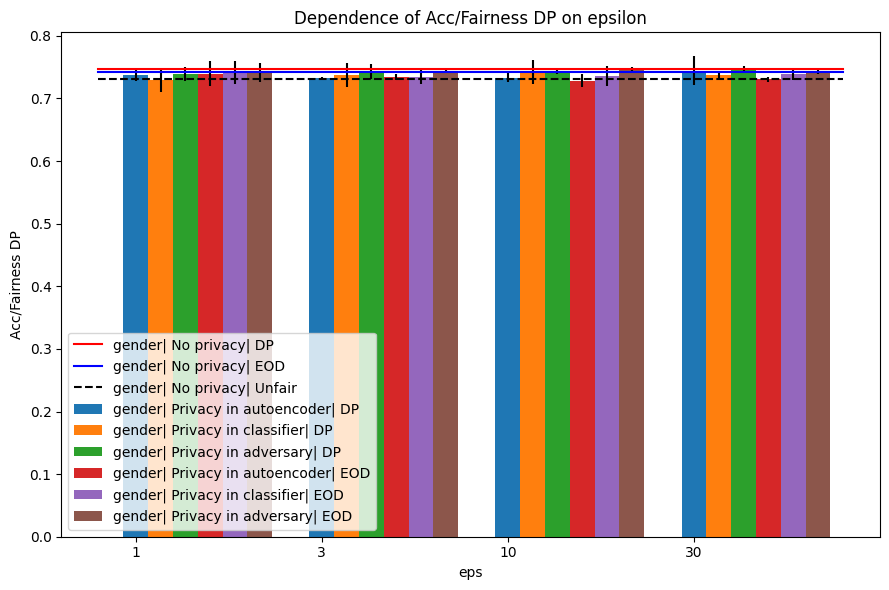

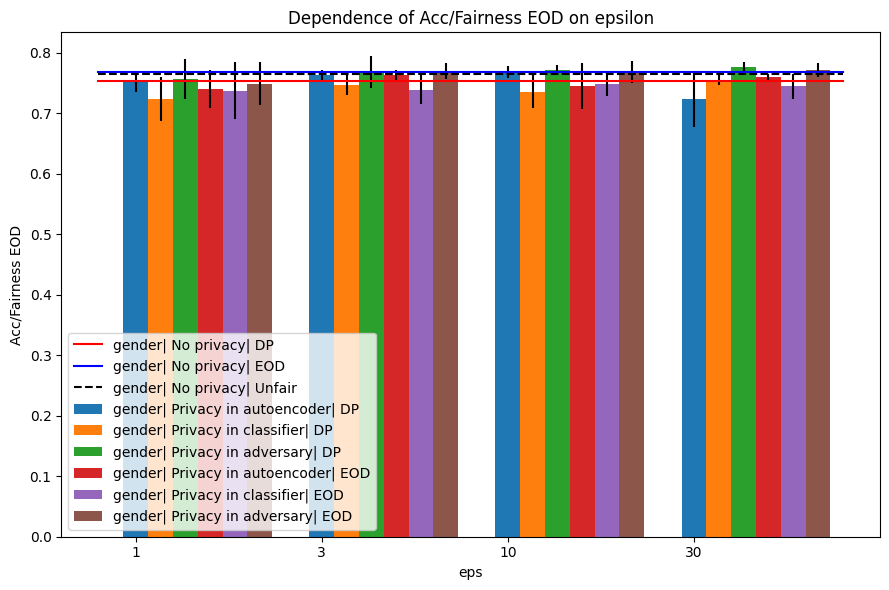

In [517]:
colors = ['r', 'b']
metrics = ['Acc/Fairness DP', 'Acc/Fairness EOD']
ids_bar = [
    (0,2,4,1,3,5)
]
ids_plt = [
    (6, 7)
]
for metric in metrics:
    for ids in zip(ids_bar, ids_plt):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
        g_bar = [gen_l(metric)[i] for i in ids[0]]
        c_bar = [comb[i] for i in ids[0]]
        ax = plot_res(fig,ax,g_bar, metric, c_bar)
        for j, idx in enumerate(ids[1]):
            ax = add_no_pr(ax, gen_l(metric)[idx], comb[idx], metric, color=colors[j])
        ax = add_unfair(ax, metric)
        #plt.savefig(f'imgs/{metric[5:]}_{ids}')
    print('='*40)

gender| Privacy in autoencoder| DP [0.738, 0.733, 0.733, 0.744] [0.01, 0.002, 0.007, 0.023]
gender| Privacy in autoencoder| EOD [0.74, 0.734, 0.729, 0.73] [0.02, 0.004, 0.011, 0.004]
gender| No privacy| DP 0.747 0.007
gender| No privacy| EOD 0.743 0.003
gender| Privacy in autoencoder| DP [0.751, 0.763, 0.768, 0.724] [0.016, 0.008, 0.009, 0.046]
gender| Privacy in autoencoder| EOD [0.741, 0.763, 0.746, 0.76] [0.032, 0.009, 0.038, 0.005]
gender| No privacy| DP 0.753 0.04
gender| No privacy| EOD 0.768 0.012


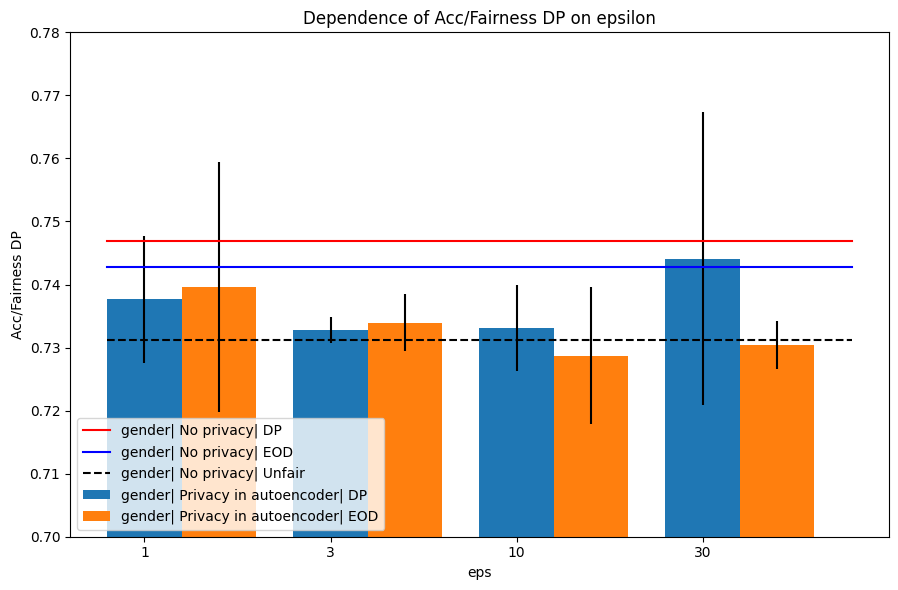

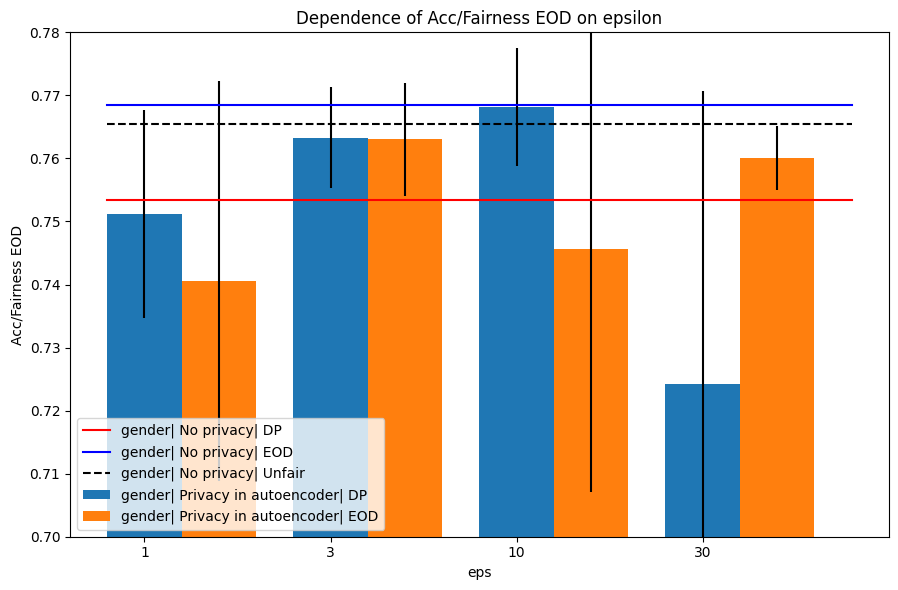

In [508]:
colors = ['r', 'b']
metrics = ['Acc/Fairness DP', 'Acc/Fairness EOD']
ids_bar = [
    (0,1)
]
ids_plt = [
    (6, 7)
]
for metric in metrics:
    for ids in zip(ids_bar, ids_plt):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
        g_bar = [gen_l(metric)[i] for i in ids[0]]
        c_bar = [comb[i] for i in ids[0]]
        ax = plot_res(fig,ax,g_bar, metric, c_bar)
        for j, idx in enumerate(ids[1]):
            ax = add_no_pr(ax, gen_l(metric)[idx], comb[idx], metric, color=colors[j])
        ax = add_unfair(ax, metric)
        ax.set_ylim(0.7, 0.78)
        plt.savefig(f'imgs/{metric[4:]}_{ids}')
    print('='*40)